# Evaluation der Imputation Methoden

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from varclushi import VarClusHi
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [2]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

base = pd.read_csv('additional_data/base.csv')

backfill = pd.read_csv('additional_data/imputed_sets/backfill.csv')
mean = pd.read_csv('additional_data/imputed_sets/mean.csv')
interpolation = pd.read_csv('additional_data/imputed_sets/interpolation.csv')
ice1 = pd.read_csv('additional_data/imputed_sets/ice.csv')
ice2 = pd.read_csv('additional_data/imputed_sets/ice2.csv')
ice3 = pd.read_csv('additional_data/imputed_sets/ice2.csv')
mice = pd.read_csv('additional_data/imputed_sets/mice.csv')
knn = pd.read_csv('additional_data/imputed_sets/knn.csv')

#sets = [base, backfill, mean, interpolation, ice, mice]

In [13]:
mean

,Country Name,Indicator Name,1990,1991,1992,1993,1994,1995,1996,1997,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Afghanistan,Access to clean fuels and technologies for coo...,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,...,21.5000,23.0000,24.8000,26.7000,28.6000,30.3000,32.2000,34.1000,36.0000,61.9032
1,Albania,Access to clean fuels and technologies for coo...,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,...,69.0000,71.2000,73.3000,74.7000,75.9000,77.6000,78.8000,79.7000,80.7000,61.9032
2,Algeria,Access to clean fuels and technologies for coo...,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,...,99.2000,99.3000,99.3000,99.3000,99.4000,99.3000,99.3000,99.3000,99.3000,61.9032
3,Angola,Access to clean fuels and technologies for coo...,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,...,44.9000,45.4000,45.7000,46.6000,47.3000,47.8000,48.4000,49.0000,49.6000,61.9032
4,Argentina,Access to clean fuels and technologies for coo...,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,61.9032,...,99.2000,99.4000,99.5000,99.6000,99.7000,99.8000,99.8000,99.8000,99.8000,61.9032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26065,Vietnam,"Vulnerable employment, total (% of total emplo...",42.0100,87.3200,86.6700,85.9500,84.9800,83.8800,82.3800,81.2600,...,62.4300,62.5200,62.6500,62.2400,57.7600,55.9200,55.1100,53.9100,52.2900,42.0100
26066,West Bank and Gaza,"Vulnerable employment, total (% of total emplo...",42.0100,32.4500,32.1000,31.9400,31.2600,31.0100,31.1800,30.7400,...,27.0200,26.7400,25.6800,25.9300,25.0300,24.0700,23.0500,23.1800,22.0400,42.0100
26067,"Yemen, Rep.","Vulnerable employment, total (% of total emplo...",42.0100,44.0400,43.8400,43.7700,43.6500,43.6400,43.7000,43.5600,...,42.4600,42.5600,42.4200,42.4400,44.0300,45.6200,46.9300,47.6300,48.0200,42.0100
26068,Zambia,"Vulnerable employment, total (% of total emplo...",42.0100,75.5100,76.0000,76.7400,77.3500,78.1300,78.3300,78.6100,...,79.7200,79.2400,78.2900,77.4100,76.8600,75.9300,74.5500,74.8800,73.2200,42.0100


In [21]:
def get_cords(frac):
    n = int(base.isna().sum().sum()*frac)
    print(f'Testdaten mit {frac*100}% fehlenden Werten (absolut: {n})')
    
    #random state to ensure reproducibility
    rnds = np.random.RandomState(n)

    #coordinates for data entries to be removed randomly
    #5000 entries are selected
    cords = pd.DataFrame([[rnds.randint(0, len(base), size=n*4)[i], 
                  rnds.randint(0, len(base.columns), size=n*4)[i]]
                  for i in range(n*4)])

    #all coordinates pointing to NaN entries are removed and
    #first 1000 remaining entries are selected
    cords['value'] = [base.iloc[cords[0][i], cords[1][i]] for i in cords.index]
    cords = cords.dropna()[:n].reset_index(drop=True)
    
    return cords

def reset_train(cords):
    train = base.copy()
    for i in cords.index:
        train.iloc[cords[0][i], cords[1][i]] = None
    return train

In [22]:
cords = get_cords(0.05)
train = reset_train(cords)

Testdaten mit 5.0% fehlenden Werten (absolut: 8515)


In [23]:
pcnt = ice.loc[ice['Indicator Name'].str.contains('%') ==True]
non_pcnt = ice.loc[ice['Indicator Name'].str.contains('%') ==False]
pcnt=pcnt.set_index(['Country Name', 'Indicator Name'])

base_pcnt = base.loc[base['Indicator Name'].str.contains('%') ==True]
base_pcnt = base_pcnt.set_index(['Country Name', 'Indicator Name'])

In [24]:
pcnt[pcnt>100]

1990  \
Country Name Indicator Name                                                         
Afghanistan  Access to clean fuels and technologies for cook... 164590027463.8795   
             Access to electricity (% of population)            198111529438.6448   
             Access to electricity, rural (% of rural popula... 198111529438.5451   
             Access to electricity, urban (% of urban popula... 205054524261.8333   
             Adjusted savings: natural resources depletion (... 189711009361.5206   
...                                                                           ...   
Zimbabwe     Unemployment, total (% of total labor force) (n... 159311957488.8130   
             Unemployment, youth total (% of total labor for...    941252069.5466   
             Urban population (% of total population)                         NaN   
             Urban population growth (annual %)                               NaN   
             Vulnerable employment, total (% of total employ...    768334430.4317   

                                                                             1991  \
Country Name Indicator Name                                                         
Afghanistan  Access to clean fuels and technologies for cook... 163098155725.0294   
             Access to electricity (% of population)            212615576360.7560   
             Access to electricity, rural (% of rural popula... 212615576360.9215   
             Access to electricity, urban (% of urban popula... 214729903348.5065   
             Adjusted savings: natural resources depletion (... 199190179539.5981   
...                                                                           ...   
Zimbabwe     Unemployment, total (% of total labor force) (n... 188964017772.7354   
             Unemployment, youth total (% of total labor for...               NaN   
             Urban population (% of total population)                         NaN   
             Urban population growth (annual %)                               NaN   
             Vulnerable employment, total (% of total employ...               NaN   

                                                                             1992  \
Country Name Indicator Name                                                         
Afghanistan  Access to clean fuels and technologies for cook... 236183392794.9705   
             Access to electricity (% of population)            210684435451.3380   
             Access to electricity, rural (% of rural popula... 210684435452.0158   
             Access to electricity, urban (% of urban popula... 208434657177.0427   
             Adjusted savings: natural resources depletion (... 179599677377.7756   
...                                                                           ...   
Zimbabwe     Unemployment, total (% of total labor force) (n... 498310612462.4475   
             Unemployment, youth total (% of total labor for...               NaN   
             Urban population (% of total population)                         NaN   
             Urban population growth (annual %)                               NaN   
             Vulnerable employment, total (% of total employ...               NaN   

                                                                             1993  \
Country Name Indicator Name                                                         
Afghanistan  Access to clean fuels and technologies for cook... 167673540287.5046   
             Access to electricity (% of population)            203979241812.4264   
             Access to electricity, rural (% of rural popula... 203979241812.2550   
             Access to electricity, urban (% of urban popula... 207874861823.4812   
             Adjusted savings: natural resources depletion (... 188924535573.8375   
...                                                                           ...   
Zimbabwe     Unemployment, total (% of total labor force) (n...               N

In [25]:
#number of values with logical errors (percentage values larger than 100%)
(pcnt>100).sum().sum()

105513

In [34]:
((base_pcnt>100).T.sum()).loc[(base_pcnt>100).T.sum()>0].to_csv('additional_data/temp.csv')

In [27]:
#number of percentage values logically sound
pcnt[pcnt>100].isna().sum().sum() - pcnt[pcnt<=0].notna().sum().sum()

293627

In [28]:
125720 + 293627

419347

In [ ]:
base_pcnt[base_pcnt>100].isna().sum().sum() - pcnt[pcnt<=0].notna().sum().sum()

In [ ]:
#nr of percentage values
(base_pcnt<=100).sum().sum()

In [40]:
(pcnt<100).sum().sum()

237651

In [31]:
base_pcnt.isna().sum().sum()

99657

In [47]:

pcnt.size

426126

In [45]:
base_pcnt.size

426126

In [70]:
def make_cluster_heatmap(df, year):
    
    df= df.reset_index()
    df = df[['Country Name', 'Indicator Name', str(year)]]
    df = df.set_index(['Country Name', 'Indicator Name']).unstack()
    df.columns = df.columns.droplevel(0)
    
    var_clus = VarClusHi(df,  maxclus=20)
    var_clus.varclus()
    df_clus = var_clus.rsquare
    df_clus.sort_values(['Cluster', 'RS_Ratio'], inplace=True)
    var = df_clus['Variable']
  
    df = df.reindex(columns=var)
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax = sns.heatmap(df.corr(), square=True, linewidths=0, annot=False,
                     vmin=-1, vmax=1, center=0,
                     cmap = sns.diverging_palette(230, 20, as_cmap=True))

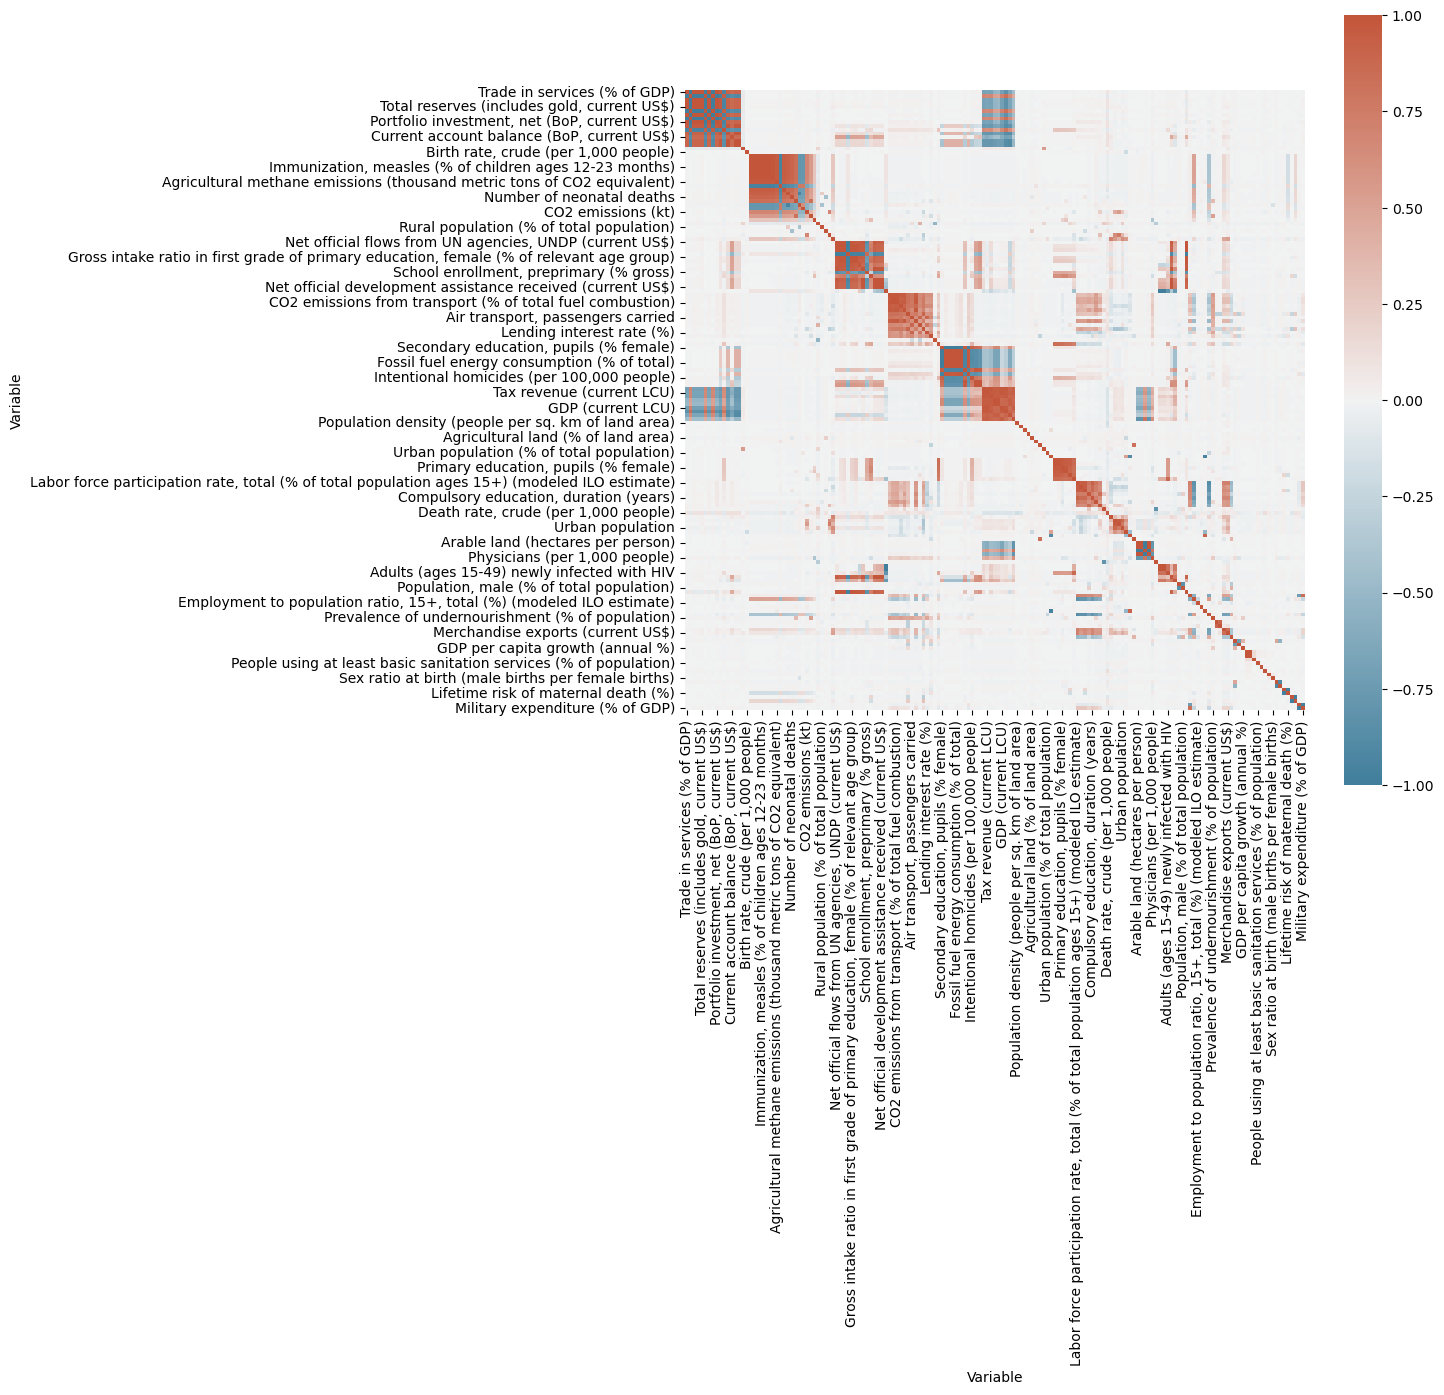

In [71]:
make_cluster_heatmap(ice3, 2014)

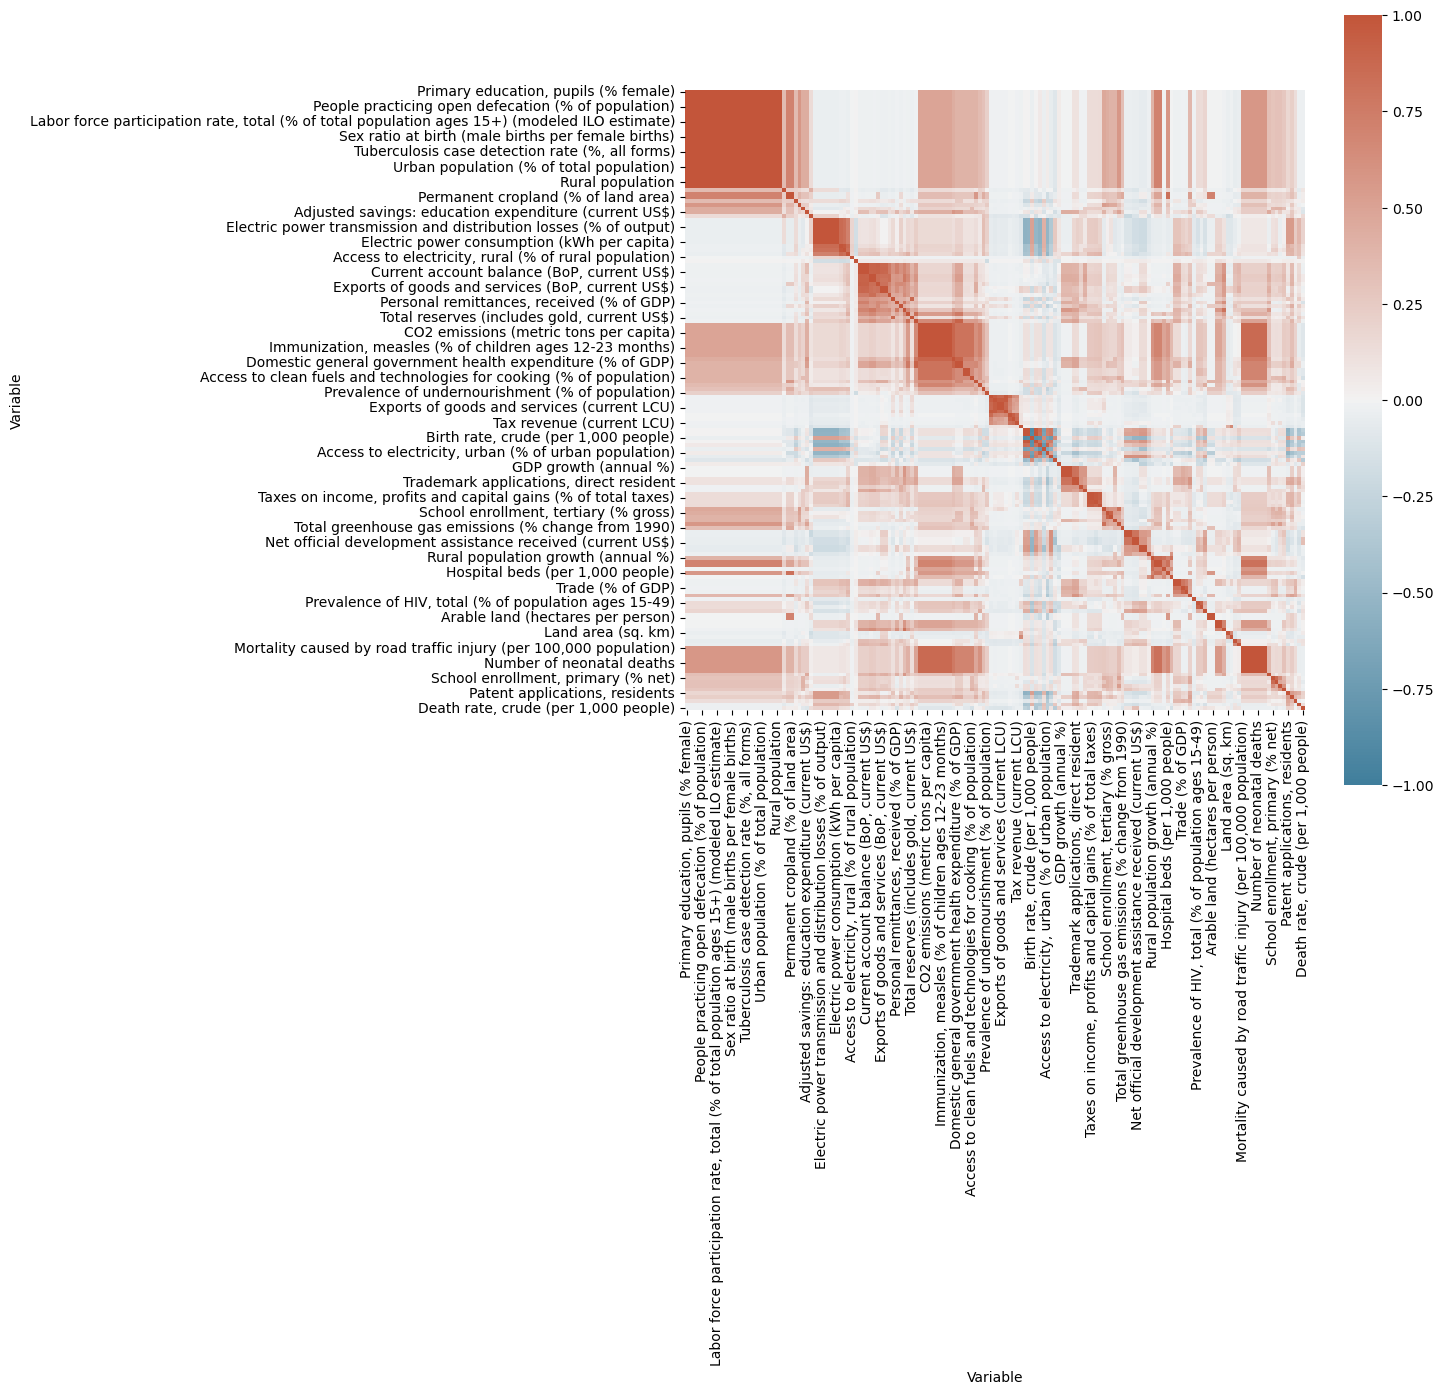

In [72]:
make_cluster_heatmap(knn, 2014)

In [66]:
sample = 'Primary education, duration (years)'

ice2.loc[ice2['Indicator Name']==sample].head(5)

,Country Name,Indicator Name,1990,1991,1992,1993,1994,1995,1996,1997,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
118,Afghanistan,"Primary education, duration (years)",6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,...,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000
283,Albania,"Primary education, duration (years)",4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,...,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,191420876.8350
448,Algeria,"Primary education, duration (years)",6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,...,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000
613,Angola,"Primary education, duration (years)",4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,...,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000
778,Argentina,"Primary education, duration (years)",7.0000,7.0000,7.0000,7.0000,7.0000,7.0000,7.0000,7.0000,...,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000


In [65]:
sample = 'Primary education, duration (years)'

ice.loc[ice['Indicator Name']==sample].head(5)

,Country Name,Indicator Name,1990,1991,1992,1993,1994,1995,1996,1997,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
118,Afghanistan,"Primary education, duration (years)",6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,...,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000
283,Albania,"Primary education, duration (years)",4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,...,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,44878532513.1428
448,Algeria,"Primary education, duration (years)",6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,...,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000
613,Angola,"Primary education, duration (years)",4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,...,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000
778,Argentina,"Primary education, duration (years)",7.0000,7.0000,7.0000,7.0000,7.0000,7.0000,7.0000,7.0000,...,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000


In [67]:
sample = 'Primary education, duration (years)'

train.loc[train['Indicator Name']=='Primary education, duration (years)'].head(5)

,Country Name,Indicator Name,1990,1991,1992,1993,1994,1995,1996,1997,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
14062,Afghanistan,"Primary education, duration (years)",6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,...,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,NaN
14063,Albania,"Primary education, duration (years)",4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,...,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000
14064,Algeria,"Primary education, duration (years)",6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,...,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000
14065,Angola,"Primary education, duration (years)",4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,4.0000,...,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000
14066,Argentina,"Primary education, duration (years)",7.0000,7.0000,7.0000,7.0000,7.0000,7.0000,7.0000,7.0000,...,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000,6.0000
